In [80]:
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import torch

from matplotlib import pyplot as plt
import seaborn as sns

from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense, Input
from keras.layers import TimeDistributed
from keras.layers import LSTM, GRU, Bidirectional, SimpleRNN, RNN
from keras.models import load_model
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical 

from transformers import BertTokenizer, BertModel

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import json

from sklearn.metrics import f1_score, accuracy_score
from keras.callbacks import Callback
import numpy as np
import pickle

In [81]:
train_data = json.load(open('../Dataset/BIO_Tagged/ATE_train.json'))
val_data = json.load(open('../Dataset/BIO_Tagged/ATE_val.json'))
test_data = json.load(open('../Dataset/BIO_Tagged/ATE_test.json'))

In [82]:
word2vec = pickle.load(open('Word Embeddings/word2vec.pkl', 'rb'))
glove = pickle.load(open('Word Embeddings/glove.pkl', 'rb'))
# Add another embedding here

In [83]:
def prepareData(train_data, embedding_type):
    X, Y = [], []
    for data in train_data:
        X.append(train_data[data]['text'].split())
        Y.append(train_data[data]['labels'])
        
    num_words = len(set([word.lower() for sentence in X for word in sentence]))       
    word_tokenizer = Tokenizer()                      
    word_tokenizer.fit_on_texts(X)                    
    X_encoded = word_tokenizer.texts_to_sequences(X)

    tag_tokenizer = Tokenizer()
    tag_tokenizer.fit_on_texts(Y)
    Y_encoded = tag_tokenizer.texts_to_sequences(Y)

    max_seq_length = 50

    X_padded = pad_sequences(X_encoded, maxlen=max_seq_length, padding="pre", truncating="post")
    Y_padded = pad_sequences(Y_encoded, maxlen=max_seq_length, padding="pre", truncating="post")

    X, Y = X_padded, Y_padded    

    embedding_matrix = np.zeros((num_words+1, 300))
    
    word2id = word_tokenizer.word_index
    for word, index in word2id.items():
        try:
            embedding_matrix[index, :] = embedding_type[word]
        except KeyError:
            pass    

    Y = to_categorical(Y)

    return X, Y, embedding_matrix, word_tokenizer, tag_tokenizer

In [84]:
word_to_idx = {}

for case in train_data:
    for text in train_data[case]['text'].split(' '):
        if text not in word_to_idx:
            word_to_idx[text] = len(word_to_idx)

for case in test_data:
    for text in test_data[case]['text'].split(' '):
        if text not in word_to_idx:
            word_to_idx[text] = len(word_to_idx)

for case in val_data:
    for text in val_data[case]['text'].split(' '):
        if text not in word_to_idx:
            word_to_idx[text] = len(word_to_idx)

In [85]:
tag_to_ix = {}

for case in train_data:
    for tag in train_data[case]['labels']:
        if tag not in tag_to_ix:
            tag_to_ix[tag] = len(tag_to_ix)

for case in test_data:
    for tag in test_data[case]['labels']:
        if tag not in tag_to_ix:
            tag_to_ix[tag] = len(tag_to_ix)

for case in val_data:
    for tag in val_data[case]['labels']:
        if tag not in tag_to_ix:
            tag_to_ix[tag] = len(tag_to_ix)

tag_to_ix['START_TAG'] = len(tag_to_ix)
tag_to_ix['END_TAG'] = len(tag_to_ix)

In [87]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained("bert-base-uncased")

In [88]:
embedding_mat = np.zeros((len(word_to_idx), 768))

for word, idx in tqdm(word_to_idx.items()):
    try:
        tokens = tokenizer.batch_encode_plus([word], return_tensors='pt', add_special_tokens=False)
    except:
        tokens = tokenizer.batch_encode_plus(['unk'], return_tensors='pt', add_special_tokens=False)
        continue
    embeddings = None
    with torch.no_grad():
        try:
            outputs = model(**tokens)
            embeddings = outputs.last_hidden_state
        except:
            tokens = tokenizer.batch_encode_plus(['unk'], return_tensors='pt', add_special_tokens=False)
            outputs = model(**tokens)
            embeddings = outputs.last_hidden_state
    embeddings = embeddings.squeeze(0)
    word_embeddings = embeddings.mean(dim = 0)
    embedding_mat[idx] = word_embeddings.squeeze(0).numpy()

 30%|███       | 1049/3495 [00:44<01:38, 24.87it/s]

In [ ]:
pickle.dump(embedding_mat, open('Word Embeddings/bert.pkl', 'wb'))

In [12]:
data = {}
data['word2vec'] = {}
data['glove'] = {}
data['bert'] = {}

data['word2vec']['X_train'], data['word2vec']['Y_train'], data['word2vec']['train_embedding_matrix'], word_tokenizer, tag_tokenizer = prepareData(train_data, word2vec)
data['word2vec']['X_val'], data['word2vec']['Y_val'], data['word2vec']['val_embedding_matrix'], _, _ = prepareData(val_data, word2vec)
data['word2vec']['X_test'], data['word2vec']['Y_test'], data['word2vec']['test_embedding_matrix'], _, _ = prepareData(test_data, word2vec)

data['glove']['X_train'], data['glove']['Y_train'], data['glove']['train_embedding_matrix'], word_tokenizer, tag_tokenizer = prepareData(train_data, glove)
data['glove']['X_val'], data['glove']['Y_val'], data['glove']['val_embedding_matrix'],  _, _ = prepareData(val_data, glove)
data['glove']['X_test'], data['glove']['Y_test'], data['glove']['test_embedding_matrix'],  _, _ = prepareData(test_data, glove)

data['bert']['X_train'], data['bert']['Y_train'], data['bert']['train_embedding_matrix'], word_tokenizer, tag_tokenizer = prepareBertData(train_data)
data['bert']['X_val'], data['bert']['Y_val'], data['bert']['val_embedding_matrix'],  _, _ = prepareBertData(val_data)
data['bert']['X_test'], data['bert']['Y_test'], data['bert']['test_embedding_matrix'],  _, _ = prepareBertData(test_data)


X shape:  (906, 50)
Y shape:  (906, 50, 4)
Embedding matrix shape:  (2405, 300)
X shape:  (219, 50)
Y shape:  (219, 50, 4)
Embedding matrix shape:  (1058, 300)
X shape:  (328, 50)
Y shape:  (328, 50, 4)
Embedding matrix shape:  (1200, 300)
X shape:  (906, 50)
Y shape:  (906, 50, 4)
Embedding matrix shape:  (2405, 300)
X shape:  (219, 50)
Y shape:  (219, 50, 4)
Embedding matrix shape:  (1058, 300)
X shape:  (328, 50)
Y shape:  (328, 50, 4)
Embedding matrix shape:  (1200, 300)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

X_encoded tf.Tensor(
[[  101  1045   102]
 [  101  3715   102]
 [  101  2009   102]
 [  101  2012   102]
 [  101  2305   102]
 [  101  1998   102]
 [  101 13558   102]
 [  101  2635   102]
 [  101  1996   102]
 [  101 11601   102]
 [  101  2007   102]
 [  101  2033   102]
 [  101  2138   102]
 [  101  1997   102]
 [  101  1996   102]
 [  101  2204   102]
 [  101  6046   102]
 [  101  2166   102]
 [  101  1012   102]], shape=(19, 3), dtype=int32)
Y_encoded [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 1.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 1.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 1.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 1.]
  [0. 0. 0. ... 0. 0. 0.]]]
X_word_embeddings tf.Tensor(
[[[-0.0853404   0.1722417

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

X_encoded tf.Tensor(
[[  101  1999   102     0]
 [  101  1996   102     0]
 [  101  4497   102     0]
 [  101  1010   102     0]
 [  101  2122   102     0]
 [  101  6097 17470   102]
 [  101  2024   102     0]
 [  101  4372 28969   102]
 [  101  1999   102     0]
 [  101  1037   102     0]
 [  101  3730   102     0]
 [  101  8903   102     0]
 [  101 17539   102     0]
 [  101  1011   102     0]
 [  101  2061   102     0]
 [  101  2017   102     0]
 [  101  2097   102     0]
 [  101  2196   102     0]
 [  101  2113   102     0]
 [  101  2055   102     0]
 [  101  1996   102     0]
 [  101 15082   102     0]
 [  101  3341   102     0]
 [  101  2127   102     0]
 [  101  2017   102     0]
 [  101  4965   102     0]
 [  101  2009   102     0]
 [  101  1010   102     0]
 [  101  2131   102     0]
 [  101  2009   102     0]
 [  101  2188   102     0]
 [  101  1010   102     0]
 [  101  3338   102     0]
 [  101  1996   102     0]
 [  101  7744   102     0]
 [  101  1998   102     0]
 [  101

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

X_encoded tf.Tensor(
[[ 101 9573  102]
 [ 101 2051  102]
 [ 101 2003  102]
 [ 101 3565  102]
 [ 101 3435  102]
 [ 101 1010  102]
 [ 101 2105  102]
 [ 101 5973  102]
 [ 101 2013  102]
 [ 101 3486  102]
 [ 101 3823  102]
 [ 101 2000  102]
 [ 101 1015  102]
 [ 101 3371  102]
 [ 101 1012  102]], shape=(15, 3), dtype=int32)
Y_encoded [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 1.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 1.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 1.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 1.]
  [0. 0. 0. ... 0. 0. 0.]]]
X_word_embeddings tf.Tensor(
[[[-0.27382547  0.10163069  0.1472103  ...  0.01644057  0.04948894
    0.04068155]
  [ 0.06560511 -0.56209445  0.3138215  ...  0.15504862  0.35752523
   -

In [13]:
class MacroF1ScoreCallback(Callback):
    def __init__(self, train_data, val_data):
        super().__init__()
        self.train_data = train_data
        self.val_data = val_data
        self.train_f1s = []
        self.val_f1s = []

    def on_epoch_end(self, epoch, logs=None):
        train_pred = np.argmax(self.model.predict(self.train_data[0]), axis=-1)
        train_true = np.argmax(self.train_data[1], axis=-1)
        train_f1 = f1_score(train_true.flatten(), train_pred.flatten(), average='macro')

        val_pred = np.argmax(self.model.predict(self.val_data[0]), axis=-1)
        val_true = np.argmax(self.val_data[1], axis=-1)
        val_f1 = f1_score(val_true.flatten(), val_pred.flatten(), average='macro')

        self.train_f1s.append(train_f1)
        self.val_f1s.append(val_f1)
        print(f'Epoch {epoch + 1} - Train Macro-F1: {train_f1:.4f} - Val Macro-F1: {val_f1:.4f}')


## VANILLA RNN

In [22]:
def trainRNN(embedding):
    X_train, Y_train, X_val, Y_val, train_embedding_matrix, val_embedding_matrix = data[embedding]['X_train'], data[embedding]['Y_train'], data[embedding]['X_val'], data[embedding]['Y_val'], data[embedding]['train_embedding_matrix'], data[embedding]['val_embedding_matrix']
    
    NUM_CLASSES = Y_train.shape[2]
    VOCABULARY_SIZE = 2405
    EMBEDDING_SIZE = 300
    MAX_SEQUENCE_LENGTH = 50

    rnn_model = Sequential()
    rnn_model.add(Embedding(input_dim=VOCABULARY_SIZE,
                            output_dim=EMBEDDING_SIZE,
                            input_length=MAX_SEQUENCE_LENGTH,
                            weights=[train_embedding_matrix],
                            trainable=True))

    rnn_model.add(SimpleRNN(64, return_sequences=True))

    rnn_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

    rnn_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])

    macro_f1_callback = MacroF1ScoreCallback(train_data=(X_train, Y_train), val_data=(X_val, Y_val))

    macro_f1_scores = rnn_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_val, Y_val), callbacks=[macro_f1_callback])

    rnn_model.save(f'Models/t2_rnn_{embedding}.h5')

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(macro_f1_scores.history['loss'], label='Training Loss')
    plt.plot(macro_f1_scores.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(macro_f1_callback.train_f1s, label='Training Macro-F1')
    plt.plot(macro_f1_callback.val_f1s, label='Validation Macro-F1')
    plt.xlabel('Epochs')
    plt.ylabel('Macro-F1 Score')
    plt.legend()

    plt.show()


Epoch 1/10
7/7 [==============================] - 0s 9ms/step
Epoch 1 - Train Macro-F1: 0.4559 - Val Macro-F1: 0.4535
8/8 [==============================] - 3s 179ms/step - loss: 1.0837 - acc: 0.8464 - val_loss: 0.6686 - val_acc: 0.8913
Epoch 2/10
7/7 [==============================] - 0s 7ms/step
Epoch 2 - Train Macro-F1: 0.4558 - Val Macro-F1: 0.4543
8/8 [==============================] - 1s 134ms/step - loss: 0.5288 - acc: 0.8913 - val_loss: 0.4060 - val_acc: 0.8953
Epoch 3/10
7/7 [==============================] - 0s 7ms/step
Epoch 3 - Train Macro-F1: 0.4627 - Val Macro-F1: 0.4560
8/8 [==============================] - 1s 143ms/step - loss: 0.3508 - acc: 0.9006 - val_loss: 0.3376 - val_acc: 0.8982
Epoch 4/10
7/7 [==============================] - 0s 7ms/step
Epoch 4 - Train Macro-F1: 0.4784 - Val Macro-F1: 0.4555
8/8 [==============================] - 1s 132ms/step - loss: 0.2978 - acc: 0.9001 - val_loss: 0.3239 - val_acc: 0.8968
Epoch 5/10
7/7 [==============================] - 0s

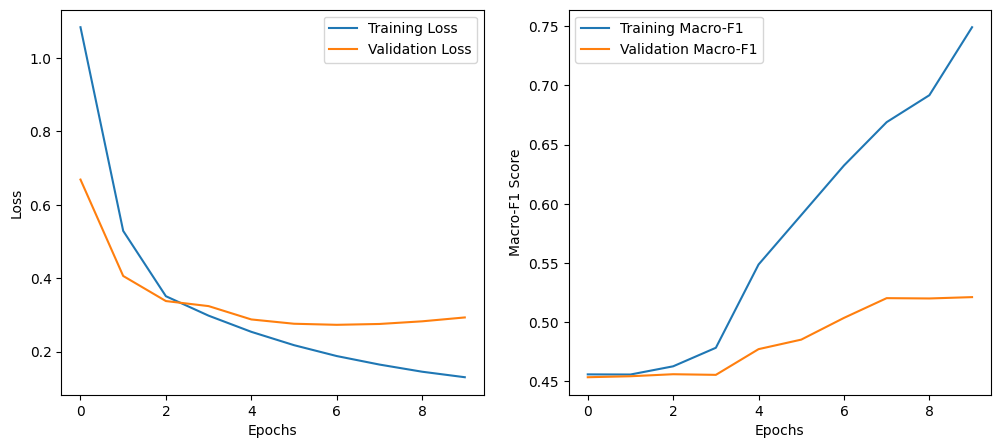

In [19]:
trainRNN('word2vec')

Epoch 1/10
7/7 [==============================] - 0s 8ms/step
Epoch 1 - Train Macro-F1: 0.4924 - Val Macro-F1: 0.4765
8/8 [==============================] - 3s 184ms/step - loss: 0.9863 - acc: 0.8796 - val_loss: 0.5458 - val_acc: 0.9100
Epoch 2/10
7/7 [==============================] - 0s 7ms/step
Epoch 2 - Train Macro-F1: 0.5336 - Val Macro-F1: 0.4862
8/8 [==============================] - 1s 112ms/step - loss: 0.4315 - acc: 0.9077 - val_loss: 0.3691 - val_acc: 0.8977
Epoch 3/10
7/7 [==============================] - 0s 7ms/step
Epoch 3 - Train Macro-F1: 0.5929 - Val Macro-F1: 0.5107
8/8 [==============================] - 1s 111ms/step - loss: 0.3002 - acc: 0.9124 - val_loss: 0.3063 - val_acc: 0.9028
Epoch 4/10
7/7 [==============================] - 0s 7ms/step
Epoch 4 - Train Macro-F1: 0.6396 - Val Macro-F1: 0.5153
8/8 [==============================] - 1s 111ms/step - loss: 0.2346 - acc: 0.9274 - val_loss: 0.2817 - val_acc: 0.9134
Epoch 5/10
7/7 [==============================] - 0s

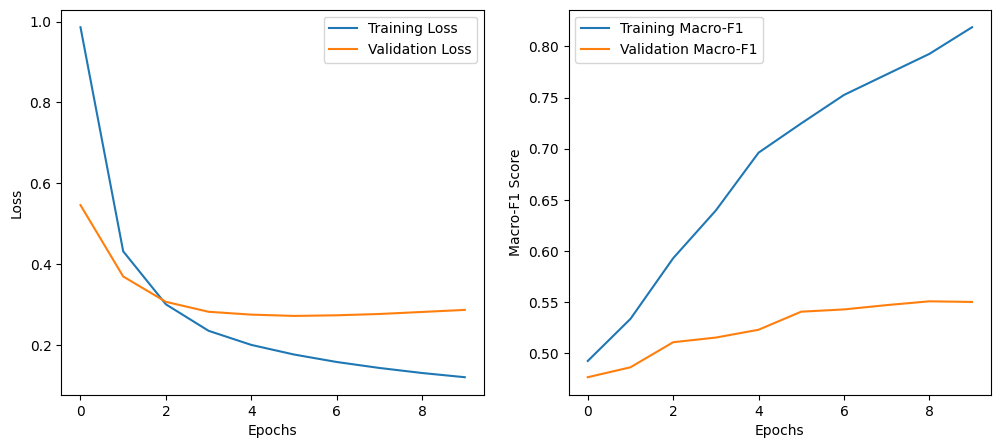

In [20]:
trainRNN('glove')

In [23]:
trainRNN('bert')

ValueError: Layer embedding_4 weight shape (2405, 300) is not compatible with provided weight shape ().

## LSTM

In [14]:
def trainLSTM(embedding):
    X_train, Y_train, X_val, Y_val, train_embedding_matrix, val_embedding_matrix = data[embedding]['X_train'], data[embedding]['Y_train'], data[embedding]['X_val'], data[embedding]['Y_val'], data[embedding]['train_embedding_matrix'], data[embedding]['val_embedding_matrix']
    
    NUM_CLASSES = Y_train.shape[2]
    VOCABULARY_SIZE = 2405
    EMBEDDING_SIZE = 300
    MAX_SEQUENCE_LENGTH = 50

    lstm_model = Sequential()
    lstm_model.add(Embedding(input_dim=VOCABULARY_SIZE,
                            output_dim=EMBEDDING_SIZE,
                            input_length=MAX_SEQUENCE_LENGTH,
                            weights=[train_embedding_matrix],
                            trainable=True))

    lstm_model.add(LSTM(64, return_sequences=True))

    lstm_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

    lstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])

    macro_f1_callback = MacroF1ScoreCallback(train_data=(X_train, Y_train), val_data=(X_val, Y_val))

    macro_f1_scores = lstm_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_val, Y_val), callbacks=[macro_f1_callback])

    lstm_model.save(f'Models/t2_lstm_{embedding}.h5')

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(macro_f1_scores.history['loss'], label='Training Loss')
    plt.plot(macro_f1_scores.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(macro_f1_callback.train_f1s, label='Training Macro-F1')
    plt.plot(macro_f1_callback.val_f1s, label='Validation Macro-F1')
    plt.xlabel('Epochs')
    plt.ylabel('Macro-F1 Score')
    plt.legend()

    plt.show()


Epoch 1/10
7/7 [==============================] - 0s 16ms/step
Epoch 1 - Train Macro-F1: 0.4657 - Val Macro-F1: 0.4642
8/8 [==============================] - 6s 426ms/step - loss: 1.2509 - acc: 0.8868 - val_loss: 1.0307 - val_acc: 0.9124
Epoch 2/10
7/7 [==============================] - 0s 12ms/step
Epoch 2 - Train Macro-F1: 0.4381 - Val Macro-F1: 0.4364
8/8 [==============================] - 2s 218ms/step - loss: 0.8607 - acc: 0.9005 - val_loss: 0.6118 - val_acc: 0.8658
Epoch 3/10
7/7 [==============================] - 0s 15ms/step
Epoch 3 - Train Macro-F1: 0.4565 - Val Macro-F1: 0.4559
8/8 [==============================] - 1s 196ms/step - loss: 0.5321 - acc: 0.8671 - val_loss: 0.4245 - val_acc: 0.8981
Epoch 4/10
7/7 [==============================] - 0s 13ms/step
Epoch 4 - Train Macro-F1: 0.4609 - Val Macro-F1: 0.4603
8/8 [==============================] - 1s 192ms/step - loss: 0.3769 - acc: 0.9041 - val_loss: 0.3386 - val_acc: 0.9058
Epoch 5/10
7/7 [==============================] 

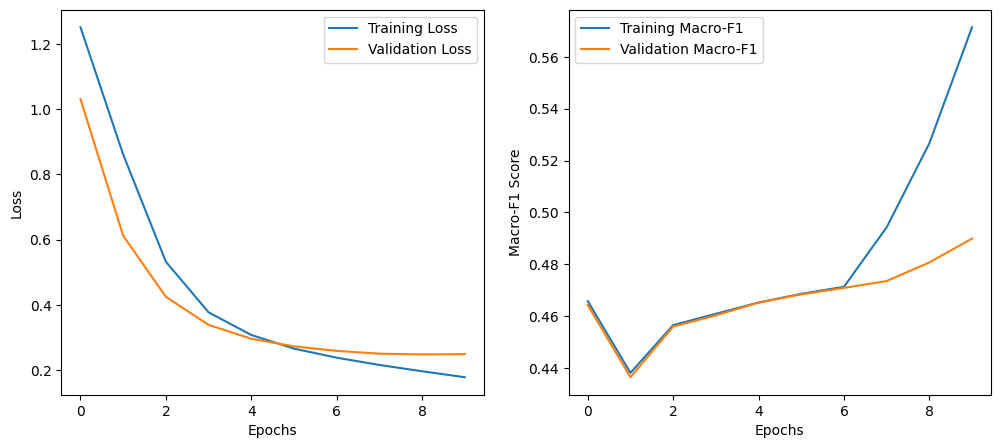

In [15]:
trainLSTM('word2vec')

Epoch 1/10
7/7 [==============================] - 0s 12ms/step
Epoch 1 - Train Macro-F1: 0.4731 - Val Macro-F1: 0.4708
8/8 [==============================] - 5s 321ms/step - loss: 1.3138 - acc: 0.7761 - val_loss: 1.0274 - val_acc: 0.9232
Epoch 2/10
7/7 [==============================] - 0s 26ms/step
Epoch 2 - Train Macro-F1: 0.4663 - Val Macro-F1: 0.4657
8/8 [==============================] - 2s 335ms/step - loss: 0.9029 - acc: 0.9215 - val_loss: 0.6896 - val_acc: 0.9146
Epoch 3/10
7/7 [==============================] - 0s 25ms/step
Epoch 3 - Train Macro-F1: 0.4472 - Val Macro-F1: 0.4467
8/8 [==============================] - 2s 330ms/step - loss: 0.5442 - acc: 0.8981 - val_loss: 0.4522 - val_acc: 0.8822
Epoch 4/10
7/7 [==============================] - 0s 29ms/step
Epoch 4 - Train Macro-F1: 0.4602 - Val Macro-F1: 0.4595
8/8 [==============================] - 2s 334ms/step - loss: 0.3932 - acc: 0.8896 - val_loss: 0.3429 - val_acc: 0.9041
Epoch 5/10
7/7 [==============================] 

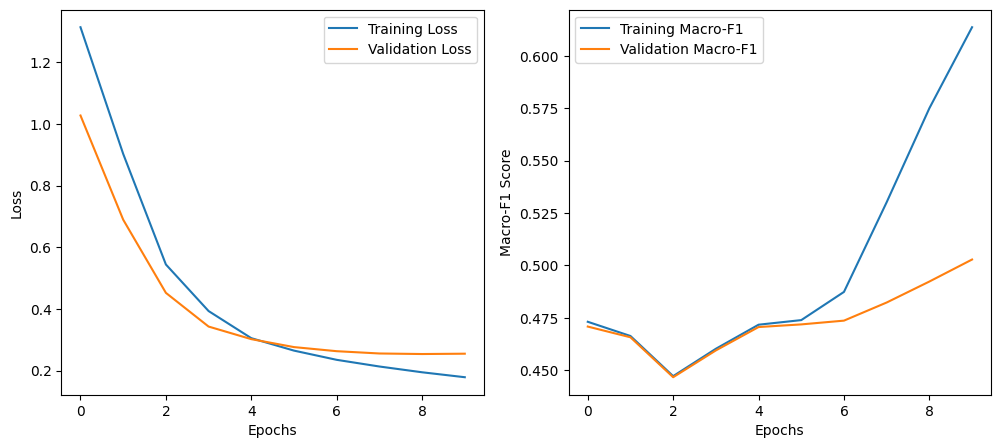

In [16]:
trainLSTM('glove')

In [ ]:
trainLSTM('bert')

## GRU

In [17]:
def trainGRU(embedding):
    X_train, Y_train, X_val, Y_val, train_embedding_matrix, val_embedding_matrix = data[embedding]['X_train'], data[embedding]['Y_train'], data[embedding]['X_val'], data[embedding]['Y_val'], data[embedding]['train_embedding_matrix'], data[embedding]['val_embedding_matrix']
    
    NUM_CLASSES = Y_train.shape[2]
    VOCABULARY_SIZE = 2405
    EMBEDDING_SIZE = 300
    MAX_SEQUENCE_LENGTH = 50

    gru_model = Sequential()
    gru_model.add(Embedding(input_dim=VOCABULARY_SIZE,
                            output_dim=EMBEDDING_SIZE,
                            input_length=MAX_SEQUENCE_LENGTH,
                            weights=[train_embedding_matrix],
                            trainable=True))

    gru_model.add(GRU(64, return_sequences=True))

    gru_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

    gru_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])

    macro_f1_callback = MacroF1ScoreCallback(train_data=(X_train, Y_train), val_data=(X_val, Y_val))

    macro_f1_scores = gru_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_val, Y_val), callbacks=[macro_f1_callback])

    gru_model.save(f'Models/t2_gru_{embedding}.h5')

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(macro_f1_scores.history['loss'], label='Training Loss')
    plt.plot(macro_f1_scores.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(macro_f1_callback.train_f1s, label='Training Macro-F1')
    plt.plot(macro_f1_callback.val_f1s, label='Validation Macro-F1')
    plt.xlabel('Epochs')
    plt.ylabel('Macro-F1 Score')
    plt.legend()

    plt.show()


Epoch 1/10
7/7 [==============================] - 0s 13ms/step
Epoch 1 - Train Macro-F1: 0.4741 - Val Macro-F1: 0.4716
8/8 [==============================] - 5s 374ms/step - loss: 1.2271 - acc: 0.9035 - val_loss: 1.0027 - val_acc: 0.9245
Epoch 2/10
7/7 [==============================] - 0s 14ms/step
Epoch 2 - Train Macro-F1: 0.4677 - Val Macro-F1: 0.4672
8/8 [==============================] - 1s 170ms/step - loss: 0.8320 - acc: 0.9228 - val_loss: 0.5701 - val_acc: 0.9173
Epoch 3/10
7/7 [==============================] - 0s 18ms/step
Epoch 3 - Train Macro-F1: 0.4587 - Val Macro-F1: 0.4575
8/8 [==============================] - 2s 202ms/step - loss: 0.4173 - acc: 0.9088 - val_loss: 0.3420 - val_acc: 0.9009
Epoch 4/10
7/7 [==============================] - 0s 17ms/step
Epoch 4 - Train Macro-F1: 0.4712 - Val Macro-F1: 0.4645
8/8 [==============================] - 1s 198ms/step - loss: 0.2888 - acc: 0.9019 - val_loss: 0.2865 - val_acc: 0.9123
Epoch 5/10
7/7 [==============================] 

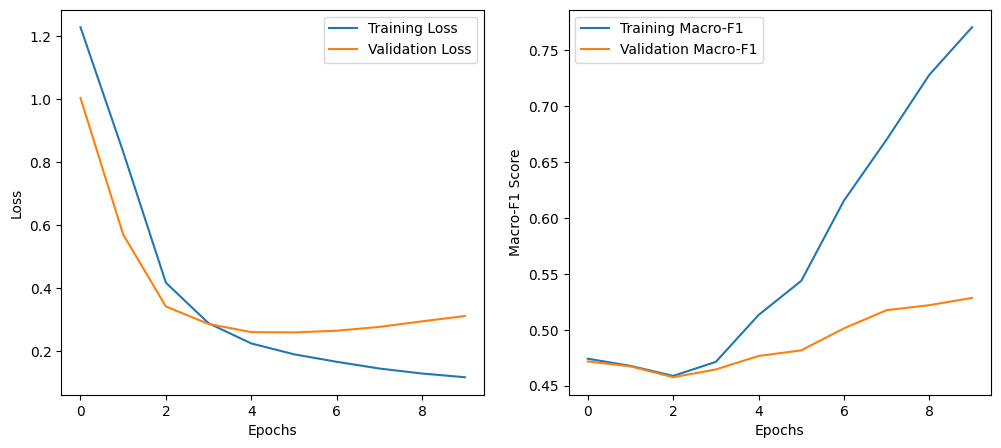

In [18]:
trainGRU('word2vec')

Epoch 1/10
7/7 [==============================] - 0s 11ms/step
Epoch 1 - Train Macro-F1: 0.4755 - Val Macro-F1: 0.4722
8/8 [==============================] - 5s 278ms/step - loss: 1.2423 - acc: 0.8219 - val_loss: 0.9710 - val_acc: 0.9253
Epoch 2/10
7/7 [==============================] - 0s 12ms/step
Epoch 2 - Train Macro-F1: 0.4793 - Val Macro-F1: 0.4737
8/8 [==============================] - 1s 150ms/step - loss: 0.8341 - acc: 0.9234 - val_loss: 0.6449 - val_acc: 0.9252
Epoch 3/10
7/7 [==============================] - 0s 22ms/step
Epoch 3 - Train Macro-F1: 0.4968 - Val Macro-F1: 0.4723
8/8 [==============================] - 1s 159ms/step - loss: 0.4591 - acc: 0.9236 - val_loss: 0.3151 - val_acc: 0.9146
Epoch 4/10
7/7 [==============================] - 0s 18ms/step
Epoch 4 - Train Macro-F1: 0.5700 - Val Macro-F1: 0.4943
8/8 [==============================] - 1s 158ms/step - loss: 0.2472 - acc: 0.9178 - val_loss: 0.2785 - val_acc: 0.9020
Epoch 5/10
7/7 [==============================] 

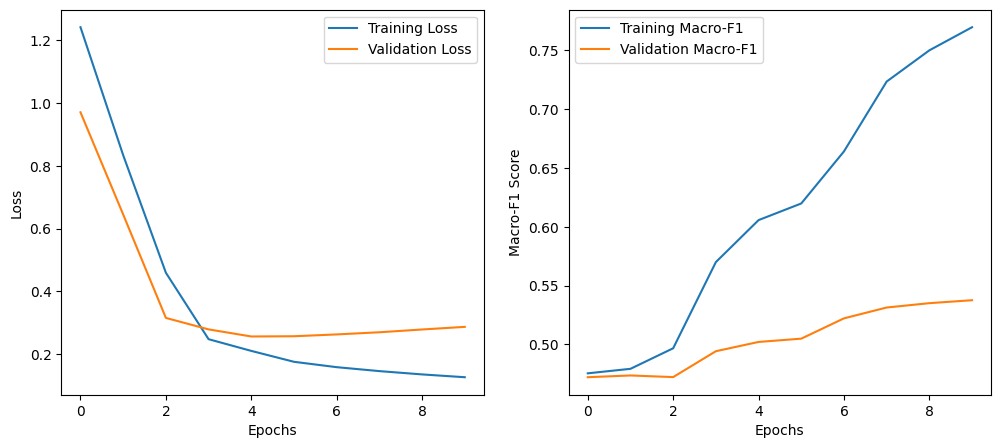

In [19]:
trainGRU('glove')

In [ ]:
trainGRU('bert')

## EVALUATION

In [20]:
def get_aspect_terms(test_pred, X_test):
    aspect_terms = []
    for i in range(len(test_pred)):
        aspect_term = []
        for j in range(len(test_pred[i])):
            if test_pred[i][j] == 1:
                aspect_term.append(word_tokenizer.index_word[X_test[i][j]])
        aspect_terms.append(aspect_term)
    return aspect_terms

In [21]:
def evaluate_model(model, X_test, Y_test):
    Y_pred = np.argmax(model.predict(X_test), axis=-1)
    Y_true = np.argmax(Y_test, axis=-1)

    aspect_terms = get_aspect_terms(Y_pred, X_test)

    print(f'Macro F1 Score: {f1_score(Y_true.flatten(), Y_pred.flatten(), average="macro"):.4f}')
    print(f'Accuracy: {accuracy_score(Y_true.flatten(), Y_pred.flatten())*100:.2f}%')

    return aspect_terms

In [24]:
rnn_word2vec = load_model('Models/t2_rnn_word2vec.h5')
rnn_glove = load_model('Models/t2_rnn_glove.h5')
rnn_bert = load_model('Models/t2_rnn_bert.h5')

lstm_word2vec = load_model('Models/t2_lstm_word2vec.h5')
lstm_glove = load_model('Models/t2_lstm_glove.h5')
lstm_bert = load_model('Models/t2_lstm_bert.h5')

gru_word2vec = load_model('Models/t2_gru_word2vec.h5')
gru_glove = load_model('Models/t2_gru_glove.h5')
gru_bert = load_model('Models/t2_gru_bert.h5')


print("RNN Word2Vec")
rnn_word2vec_aspect_terms = evaluate_model(rnn_word2vec, data['word2vec']['X_test'], data['word2vec']['Y_test'])

print()
print("RNN Glove")
rnn_glove_aspect_terms = evaluate_model(rnn_glove, data['glove']['X_test'], data['glove']['Y_test'])

print()
print("RNN bert")
rnn_bert_aspect_terms = evaluate_model(rnn_bert, data['bert']['X_test'], data['bert']['Y_test'])

print()
print("LSTM Word2Vec")
lstm_word2vec_aspect_terms = evaluate_model(lstm_word2vec, data['word2vec']['X_test'], data['word2vec']['Y_test'])

print()
print("LSTM Glove")
lstm_glove_aspect_terms = evaluate_model(lstm_glove, data['glove']['X_test'], data['glove']['Y_test'])

print()
print("LSTM bert")
lstm_bert_aspect_terms = evaluate_model(lstm_bert, data['bert']['X_test'], data['bert']['Y_test'])

print()
print("GRU Word2Vec")
gru_word2vec_aspect_terms = evaluate_model(gru_word2vec, data['word2vec']['X_test'], data['word2vec']['Y_test'])

print()
print("GRU Glove")
gru_glove_aspect_terms = evaluate_model(gru_glove, data['glove']['X_test'], data['glove']['Y_test'])

print()
print("GRU bert")
gru_bert_aspect_terms = evaluate_model(gru_bert, data['bert']['X_test'], data['bert']['Y_test'])

RNN Word2Vec
11/11 [==============================] - 0s 8ms/step
Macro F1 Score: 0.5388
Accuracy: 90.84%

RNN Glove
11/11 [==============================] - 0s 8ms/step
Macro F1 Score: 0.5311
Accuracy: 90.79%

LSTM Word2Vec
11/11 [==============================] - 1s 15ms/step
Macro F1 Score: 0.4959
Accuracy: 91.90%

LSTM Glove
11/11 [==============================] - 1s 21ms/step
Macro F1 Score: 0.5019
Accuracy: 91.61%

GRU Word2Vec
11/11 [==============================] - 1s 17ms/step
Macro F1 Score: 0.5225
Accuracy: 90.68%

GRU Glove
11/11 [==============================] - 1s 17ms/step
Macro F1 Score: 0.5280
Accuracy: 90.80%
